# Trading Strategy

Based on our findings in Insider_Trading.ipynb we build a really simple trading strategy. Even though we found that there is no correlation between insider selling volume and market cycles over time, we want to exploit the information that the transaction volume is always very high in March and increases toward the end of the year, especially the sell transaction volume.

Therefore, we want to check if it is a good trading strategy to buy shares in March and hold it until October before the increase in sell transaction volume usually happens.

As share we choose the share ticker IEP, since it is in the top 15 most bought companies in 2018-2023.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statistics
from scipy.stats import norm
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

First, we read the return data for the ticker IEP from the csv file provided in Data.ipynb and adjust the data to work with it.

In [2]:
# read close_prices_returns.csv to acces price data from IEP

df = pd.read_csv('close_prices_returns.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['issuerTicker', 'Date'])
df = df.reset_index().dropna().set_index(['issuerTicker', 'Date'])
df = df.loc[pd.IndexSlice[:, '2018':], :] 
df = df.loc['IEP']
df

,adjClosePrice,unadjClosePrice,returns
Date,,,
2018-01-10,23.9971,56.500,0.068861
2018-01-11,23.9249,56.330,-0.003009
2018-01-16,23.7295,55.870,-0.008167
2018-01-17,23.7422,55.900,0.000535
2018-01-18,23.6998,55.800,-0.001786
...,...,...,...
2023-11-16,17.2510,17.251,-0.071029
2023-11-27,17.2500,17.250,-0.000058
2023-12-01,17.2300,17.230,-0.001159


As benchmark we choose the S&P 500 index and read the returns for the index like above.

In [3]:
# read adjusted close price from csv file

# use S&P 500 as a benchmark for performance

benchmark_df = pd.read_csv('close_prices_returns.csv')
benchmark_df['Date'] = pd.to_datetime(benchmark_df['Date'])
benchmark_df = benchmark_df.set_index(['issuerTicker', 'Date'])
benchmark_df = benchmark_df.reset_index().dropna().set_index(['issuerTicker', 'Date']) 
benchmark_df = benchmark_df.loc[pd.IndexSlice[:, '2018':], :] 
benchmark_df = benchmark_df.loc['SPY']
benchmark_df

,adjClosePrice,unadjClosePrice,returns
Date,,,
2018-01-02,242.8990,268.58,0.003587
2018-01-03,244.5631,270.42,0.006851
2018-01-04,245.5760,271.54,0.004142
2018-01-05,247.2219,273.36,0.006702
2018-01-08,247.7374,273.93,0.002085
...,...,...,...
2023-12-14,470.1238,472.03,0.003124
2023-12-18,471.7000,471.70,0.003353
2023-12-19,474.8500,474.85,0.006678


The following code calculates the following performance measures: Alpha, beta, arithmetic and geometric mean return, Sharpe and Sortino ratios, compound annual grow (CAGR). Alpha and Beta are computed using OLS regression.

In [4]:
def calculate_performance_measures(df, benchmark_df):
    
    # Calculate cumulative returns
    df['cumulative returns'] = (1 + df['returns']).cumprod()
    benchmark_df['cumulative returns'] = (1 + benchmark_df['returns']).cumprod()
    
    # Merge dataframes on date
    merged_df = df[['returns']].merge(benchmark_df[['returns']], left_index=True, right_index=True, suffixes=('', '_benchmark'))
    
    # Alpha and Beta
    X = merged_df['returns_benchmark'].dropna()
    Y = merged_df['returns'].dropna()
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    alpha = model.params['const']
    beta = model.params['returns_benchmark']

    # Mean returns
    arithmetic_mean_return = df['returns'].mean()
    geometric_mean_return = (df['cumulative returns'][-1])**(1/len(df)) - 1

    # Sharpe Ratio
    risk_free_rate = 0.01  # Assume a risk-free rate of 1%
    sharpe_ratio = (arithmetic_mean_return - risk_free_rate) / df['returns'].std()

    # Sortino Ratio
    downside_risk = np.sqrt(np.mean(np.minimum(0, df['returns'] - risk_free_rate)**2))
    sortino_ratio = (arithmetic_mean_return - risk_free_rate) / downside_risk

    # CAGR
    n_years = (df.index[-1] - df.index[0]).days / 365.25
    cagr = (df['cumulative returns'][-1])**(1/n_years) - 1

    # Maximum Drawdown
    rolling_max = df['cumulative returns'].cummax()
    drawdown = df['cumulative returns'] / rolling_max - 1
    max_drawdown = drawdown.min()

    # Volatility
    volatility = df['returns'].std() * np.sqrt(252)  # Annualized volatility

    performance_measures = {
        'Alpha': alpha,
        'Beta': beta,
        'Arithmetic Mean Return': arithmetic_mean_return,
        'Geometric Mean Return': geometric_mean_return,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'CAGR': cagr,
        'Max Drawdown': max_drawdown,
        'Volatility': volatility
    }

    return performance_measures

The following code defines the trading strategy to buy shares in March and sell them in October by setting a position of 1 during these months.

In [5]:
def trading_strategy(df):
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    df['Position'] = 0  # Initialize position column
    df.loc[(df['Month'] >= 3) & (df['Month'] <= 10), 'Position'] = 1  # Buy in March, sell in October

    df['strategy returns'] = df['Position'].shift(1) * df['returns']
    df['cumulative strategy returns'] = (1 + df['strategy returns'].fillna(0)).cumprod()

    return df

Next, we apply the trading strategy and plot the performance of the strategy. We do this for the time period 2018-2023 and annually.

Alpha: -0.0003014990980364802
Beta: 0.7317905149687319
Arithmetic Mean Return: 0.0003405890655079551
Geometric Mean Return: -0.00046532982142977186
Sharpe Ratio: -0.22993184358021626
Sortino Ratio: -0.3188048598841818
CAGR: -0.05093477943524449
Max Drawdown: -0.653283936072917
Volatility: 0.6668862932452795


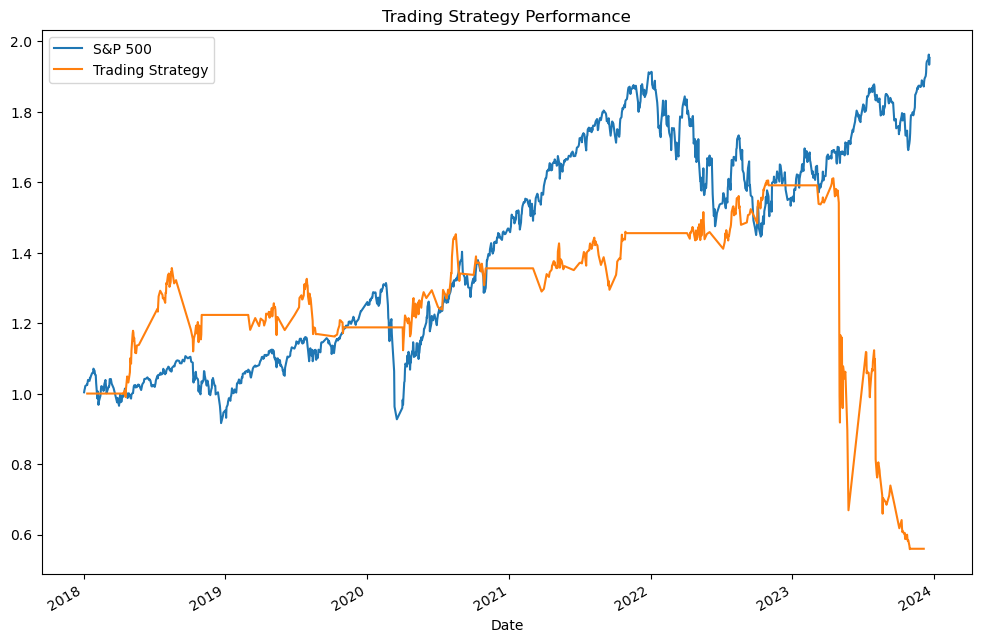

In [6]:
# Apply trading strategy for 2018-2023
stock_df = trading_strategy(df)

benchmark_df['cumulative returns'] = (1 + benchmark_df['returns']).cumprod()

# Calculate performance measures for each year
#years = stock_df['Year'].unique() 
#performance_measures = pd.DataFrame()

#benchmark_df['Year'] = benchmark_df.index.year

#for index, year in enumerate(years) :
#    performance_measures[index] = calculate_performance_measures(stock_df[stock_df['Year'] == year], benchmark_df[benchmark_df['Year'] == year])

# Calculate performance measures
performance_measures = calculate_performance_measures(stock_df, benchmark_df)

# Print performance measures
for measure, value in performance_measures.items():
    print(f"{measure}: {value}")

# Plot strategy performance
plt.figure(figsize=(12, 8))
benchmark_df['cumulative returns'].plot(label='S&P 500')
stock_df['cumulative strategy returns'].plot(label='Trading Strategy')
plt.legend()
plt.title('Trading Strategy Performance')
plt.show()

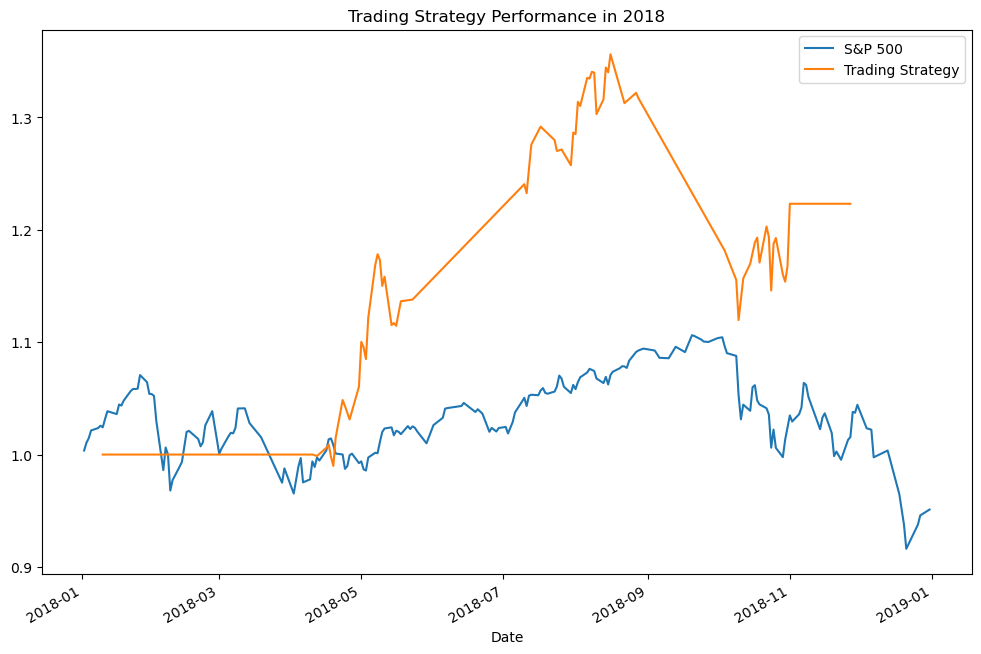

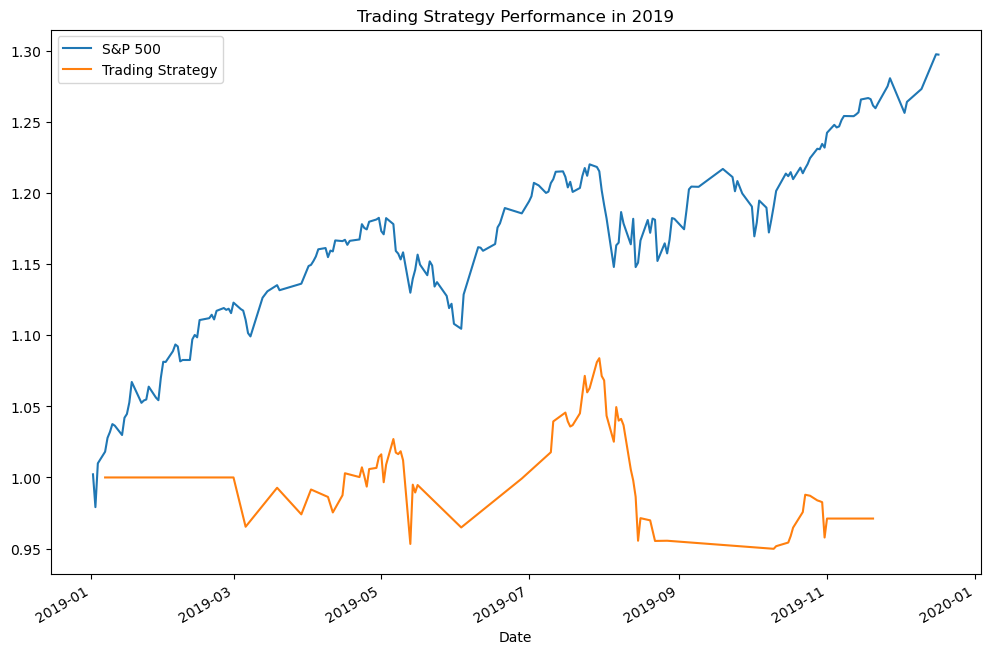

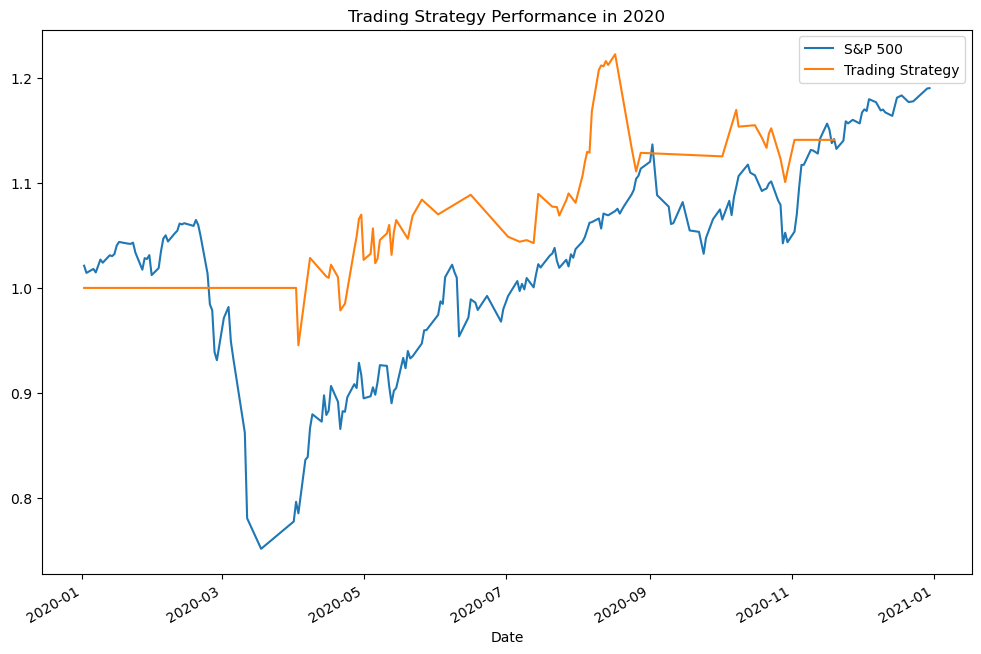

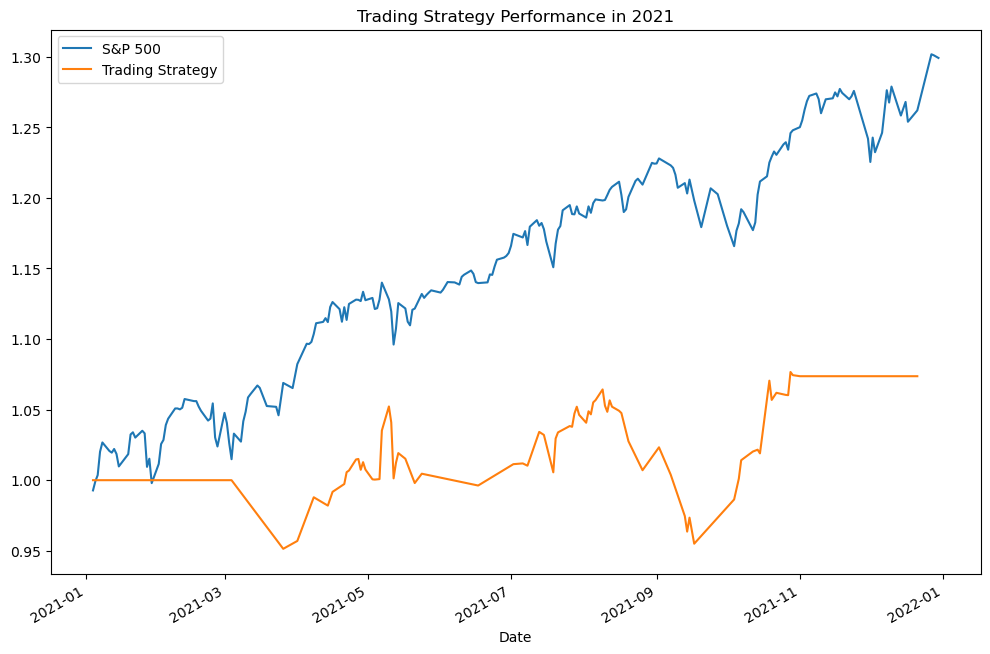

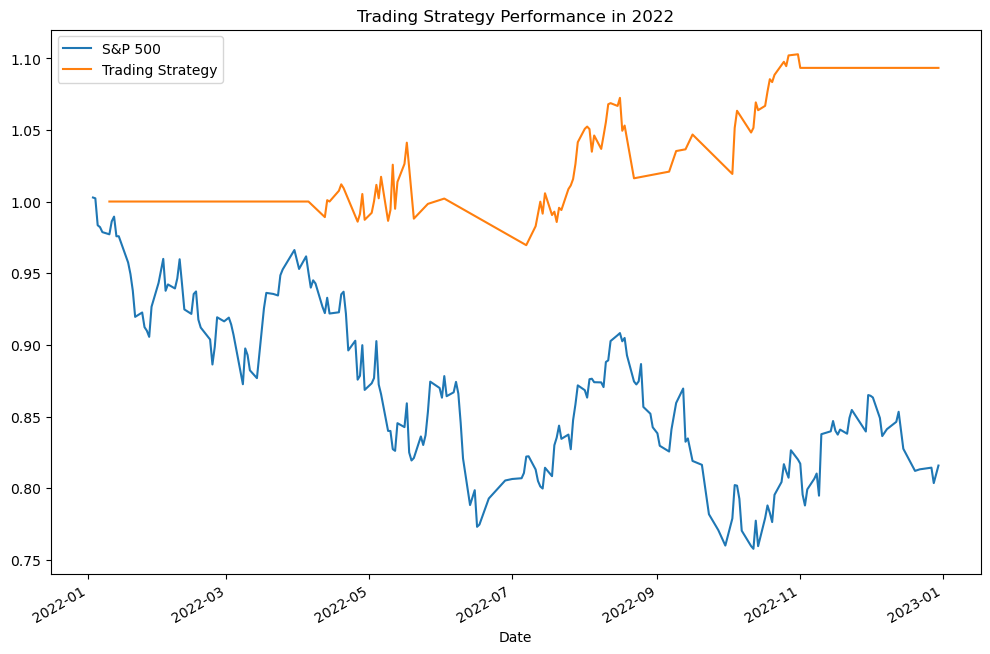

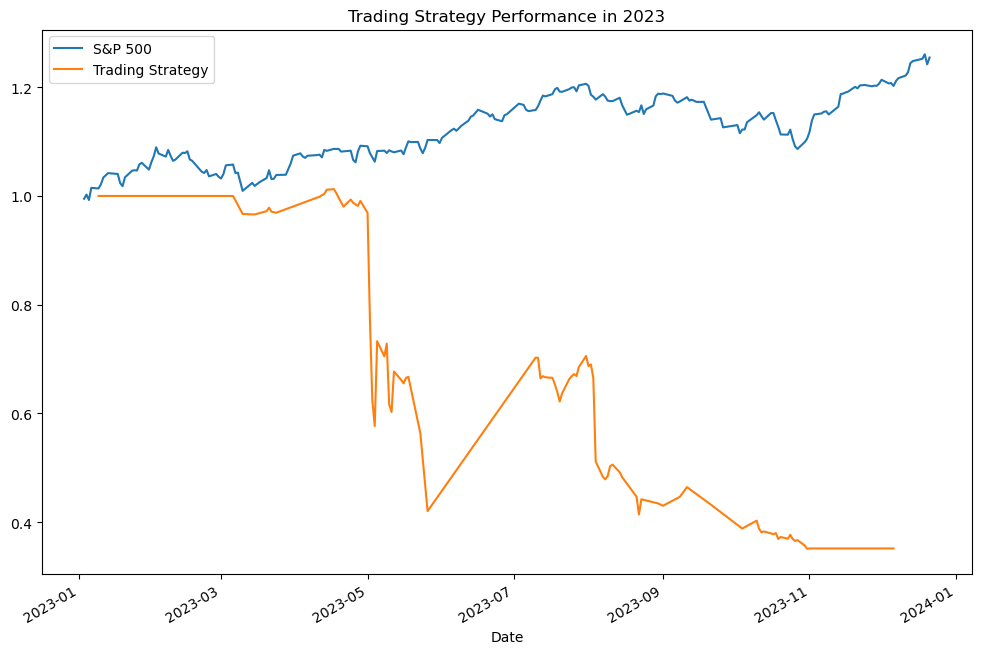

In [8]:
# Apply trading strategy for each year

performance_measures = pd.DataFrame()
performance_measures_benchmark = pd.DataFrame()

df['Year'] = df.index.year
benchmark_df['Year'] = benchmark_df.index.year

for year in range(2018,2024) :
    stock_df = trading_strategy(df[df['Year']==year])
    b_df = benchmark_df[benchmark_df['Year']==year]
    b_df['cumulative returns'] = (1 + b_df['returns']).cumprod()
    
    # Calculate performance measures for each year
    performance_measures[str(year)] = calculate_performance_measures(stock_df, b_df)
    performance_measures_benchmark[str(year)] = calculate_performance_measures(b_df, stock_df)
    
    # Plot strategy performance
    plt.figure(figsize=(12, 8))
    b_df['cumulative returns'].plot(label='S&P 500')
    stock_df['cumulative strategy returns'].plot(label='Trading Strategy')
    plt.legend()
    plt.title(f'Trading Strategy Performance in {year}')
    plt.show()

In 2018, 2020 and 2022 the trading strategy performed better than the S&P 500 index. \
In 2019, 2021 and 2023 the trading strategy performed worse than the S&P 500 index.

In 2023 Hindenburg Research released a report calling Icahn Enterprises "substantially overvalued" and argued that IEP relied on a "Ponzi-like" structure to fund its dividend. The stock lost about half of its value following the Hindenburg report and has never recovered.

Interestingly the performance of the trading strategy always changes each year. It is always better or worse thant the index, but there is no in-between.

Looking at the performance measures down below, one can find similar results.

In [9]:
performance_measures

,2018,2019,2020,2021,2022,2023
Alpha,0.003593,0.000332,-0.001993,0.000405,0.001466,-0.005183
Beta,1.083381,1.033145,0.674919,0.716878,0.312722,1.530078
Arithmetic Mean Return,0.003540,0.000688,-0.000230,0.001501,0.001566,-0.004181
Geometric Mean Return,0.003186,0.000507,-0.000720,0.001246,0.001458,-0.007167
Sharpe Ratio,-0.240314,-0.482846,-0.336270,-0.380349,-0.568152,-0.170995
Sortino Ratio,-0.304094,-0.518618,-0.343953,-0.396256,-0.543930,-0.267936
CAGR,0.457039,0.061363,-0.078498,0.153229,0.194060,-0.640817
Max Drawdown,-0.174383,-0.154004,-0.311783,-0.176908,-0.068702,-0.653284
Volatility,0.426758,0.306140,0.482950,0.354731,0.235637,1.316548


In [10]:
performance_measures_benchmark.drop(index=['Alpha', 'Beta'])

,2018,2019,2020,2021,2022,2023
Arithmetic Mean Return,-0.000176,0.001321,0.000971,0.001215,-0.000812,0.001046
Geometric Mean Return,-0.000237,0.001283,0.000826,0.001179,-0.000942,0.001009
Sharpe Ratio,-0.928221,-0.993346,-0.532716,-1.043405,-0.668295,-1.038448
Sortino Ratio,-0.688537,-0.723382,-0.499092,-0.739889,-0.591756,-0.730418
CAGR,-0.049231,0.312981,0.191648,0.304035,-0.186166,0.265425
Max Drawdown,-0.171797,-0.065939,-0.294317,-0.050620,-0.244423,-0.099359
Volatility,0.174036,0.138705,0.269044,0.133663,0.256822,0.136880


The trading strategy does not perform that well, but also not that bad compared to the S&P 500 index throughout the years. All in all, the trading strategy is not recommendable for the ticker IEP, which aligns with our findings that insider transactions are not correlated with stock prices. Perhaps other tickers or portfolios of tickers work better with this trading strategy.